# **Training Colab**

This Colab serves for model training.
For it to work, a folder called `battery_soh` must be created on google drive and include another folder called `Battery_SOH_` + the date of the most current version (`day_month`). This `Battery_SOH` should contain all of the necessary files (`Pytorch_Dataset.py`, `Training.py`, `NN_Classes.py`, `Nasa_Classes.py` and the dataset files).

An example can be found in the following google drive link (you'll need to ask for access):
https://drive.google.com/drive/folders/1G5xLrXHlKq3QpOzaFGusB89_erZPYwa6?usp=sharing 



The following cell includes the bare minimum to mount google drive to google colab so that the files can be directly called. The `root_path` may have to be updated to the latest `Battery_SOH` folder.

In [ ]:
from google.colab import drive
import os
import torch as th

# Mounting google drivee
drive.mount('/content/gdrive')
folder_name = 'Battery_SOH_24_06_15h'
# The root path will change depending on the latest 'bakcup'
root_path = 'gdrive/My Drive/battery_soh/' + folder_name
os.chdir(root_path)
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
device

Mounted at /content/gdrive


device(type='cpu')

The cell should output something like:
```
Mounted at /content/gdrive
device(type='cuda', index=0)
```

If the second line says `device(type='cpu')` then you should change your environment options above for GPU for faster results.

In [ ]:
!pip install PyAstronomy
from Severson_Classes_tests import *
from LSTM import *
from RNN import *
from Training import *
from Load_Save import *
from torch.utils.data import DataLoader
from datetime import datetime
import re
from Coin_Classes import *
from Testing import *

     |████████████████████████████████| 716kB 17.4MB/s 
  Created wheel for PyAstronomy: filename=PyAstronomy-0.16.0-cp37-none-any.whl size=504498 sha256=2ee1eec86c88745c5a9391322f0499e011f8315fd0320ed37033aa3e8f03ff4c
  Stored in directory: /root/.cache/pip/wheels/93/af/aa/931d34dfc98c7f7fb4514fb9da32cac3584895cc03e873bdd1
Successfully built PyAstronomy


In [ ]:
DELTA = 10
fixed_len = 150
batch_size = 1
time_step = 30
LSTM_version = 4
norm_type = 'zscore'

In [ ]:
# os.chdir('.//Datasets/NASA/B. Saha and K Goebel/Separate_pickles')
# dataset_name = 'Nasa'

# os.chdir('.//Datasets/Severson et al./Cleaned_v2/2. 2017-06-30')
# dataset_name = 'Sev'

os.chdir('.//Datasets/Tarascon/Coins/Clean_Batteries')
dataset_name = 'Coin'

files = os.listdir()    # All files in the folder
file_list = []          # List with the valid files

for file_name in files:
    match = re.search(r'B\d{4}.txt', file_name) # Only take into acount
                                                # the battery files
    if match == None:
        continue
    else:
        file_list.append(file_name)
file_list.sort()


if dataset_name == 'Nasa':
    ignore = ['B0049.txt', 'B0050.txt', 'B0051.txt', 'B0052.txt']

    # The big one
    train = ['B0018.txt',  # 24ºC
            #  'B0025.txt', 'B0026.txt', 'B0027.txt',  # 24ºC
            'B0029.txt', 'B0030.txt', 'B0031.txt',  # 43ºC
            'B0036.txt',  # 24ºC
            'B0038.txt', 'B0039.txt',  # 44ºC et 24ºC
            'B0042.txt', 'B0043.txt',  # 44ºC et 4ºC
            'B0045.txt', 'B0046.txt',  # 4ºC
            'B0053.txt', 'B0055.txt']  # 4ºC

elif dataset_name == 'Coin':
    train = ['B'+str(i).zfill(4)+'.txt' for i in range(1, 8)]
    ignore = train

elif dataset_name == 'Sev':

    train_len = 36
    valid_len = 12

    train = ['B'+str(i).zfill(4)+'.txt' for i in range(12, 48)]
    ignore = ['B'+str(i).zfill(4)+'.txt' for i in range(12 - valid_len)]

    # print(train, '\n', ignore)

    Train_list = []
    for file_name in file_list:
        if file_name in train:
            with open(file_name, 'rb') as f:
                Battery = pickle.load(f)
            Train_list.append(Battery)

# Training files:
Train_list = []
for file_name in file_list:
    if file_name not in train:
        continue
    else:
        with open(file_name, 'rb') as f:
            Battery = pickle.load(f)

        Train_list.append(Battery)

# train_dataset = Torch_Dataset_LSTM_test(Train_list, DELTA, LSTM_version,  # Dataset
#                                    print_bool=True, time_step=time_step, 
#                                    fixed_len=fixed_len, norm_type=norm_type)

train_dataset = Torch_Dataset_LSTM(Train_list, DELTA, LSTM_version,  # Dataset
                                   print_bool=True, time_step=time_step, 
                                   fixed_len=fixed_len, norm_type=norm_type)

if train_dataset.fixed_len is None:
    train_loader = DataLoader(dataset=train_dataset, batch_size=1,  # Loader
                                shuffle=True, num_workers=0)
else:
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,  # Loader
                                shuffle=True, num_workers=0)

if train_dataset.fixed_len is None:
    sim_train_loader = DataLoader(dataset=train_dataset, batch_size=1, 
                                  shuffle=False)
else:
    sim_train_loader = DataLoader(dataset=train_dataset, 
                                  batch_size=len(train_dataset), shuffle=False)


# Validation files:
Valid_list = []
for file_name in file_list:
    if (file_name not in train) and (file_name not in ignore):
        with open(file_name, 'rb') as f:
            Battery = pickle.load(f)
        Valid_list.append(Battery)

# valid_dataset = Torch_Dataset_LSTM_test(Valid_list, DELTA, LSTM_version, # Dataset
#                                    print_bool=True, time_step=time_step,
#                                    norm=train_dataset.norm, 
#                                    fixed_len=train_dataset.fixed_len)

valid_dataset = Torch_Dataset_LSTM(Valid_list, DELTA, LSTM_version, # Dataset
                                   print_bool=True, time_step=time_step,
                                   norm=train_dataset.norm, 
                                   fixed_len=train_dataset.fixed_len)

if train_dataset.fixed_len is None:
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=1,  # Loader
                                shuffle=False, num_workers=0)
else:
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=len(valid_dataset),  # Loader
                              shuffle=False, num_workers=0)
    
os.chdir('../../../../')

B0001
B0001
B0002
B0002
B0003
B0003
B0004
B0004
B0005
B0006
B0006
646
B0008
B0009
B0010
B0010
B0011
112


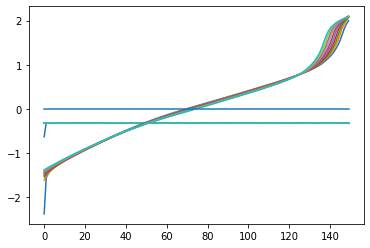

In [ ]:
plt.plot(train_dataset.inputs[-1])
plt.show()

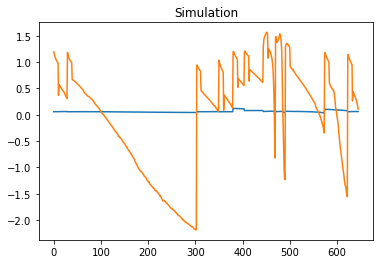

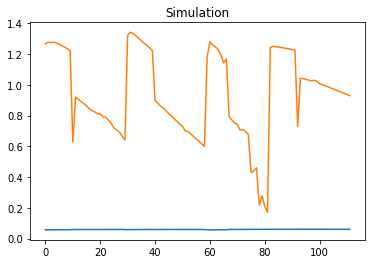

In [ ]:
HIDDEN_DIM = 50
DROPOUT = 0
pool_type = 'bi_mean'

Model = LSTM_v4(DELTA, HIDDEN_DIM, pooling_layer=pool_type, 
               drop_out=DROPOUT, version = LSTM_version,
               norm = train_dataset.norm,
               lin_dropout=0.3).to(device)

# os.chdir('.//Reports/2021-06-17 11_20_39.769117-Prés_new')
# with open('best_model.txt', 'rb') as f:
#     Model = pickle.load(f)

# Model = Model.to(device)

simulate(sim_train_loader, Model, device=device, denormalize=False)
simulate(valid_loader, Model, device=device, denormalize=False)

In [ ]:
#os.chdir('../../../../')
# os.chdir('../../')
# os.chdir('../')
# print(date)
print(os.getcwd())

/content/gdrive/My Drive/battery_soh/Battery_SOH_24_06_15h


1 . Training loss:  tensor(0.9737)
1 . Validation loss:  tensor(0.8419)
2 . Training loss:  tensor(0.9424)
2 . Validation loss:  tensor(0.8353)
3 . Training loss:  tensor(0.8947)
3 . Validation loss:  tensor(0.8296)
4 . Training loss:  tensor(0.8253)
4 . Validation loss:  tensor(0.8228)
5 . Training loss:  tensor(0.7369)
5 . Validation loss:  tensor(0.8174)
6 . Training loss:  tensor(0.6431)
6 . Validation loss:  tensor(0.8103)
7 . Training loss:  tensor(0.5558)
7 . Validation loss:  tensor(0.8018)
8 . Training loss:  tensor(0.4799)
8 . Validation loss:  tensor(0.7853)
9 . Training loss:  tensor(0.4179)
9 . Validation loss:  tensor(0.7609)
10 . Training loss:  tensor(0.3670)
10 . Validation loss:  tensor(0.7190)
11 . Training loss:  tensor(0.3241)
11 . Validation loss:  tensor(0.6752)
12 . Training loss:  tensor(0.2872)
12 . Validation loss:  tensor(0.6279)
13 . Training loss:  tensor(0.2559)
13 . Validation loss:  tensor(0.5695)
14 . Training loss:  tensor(0.2297)
14 . Validation loss

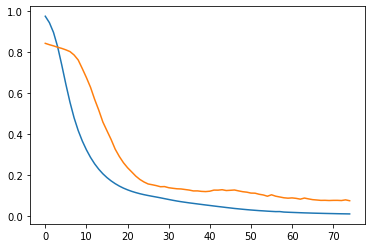

Best validation error:  75
2021-07-06 10_32_56.886364


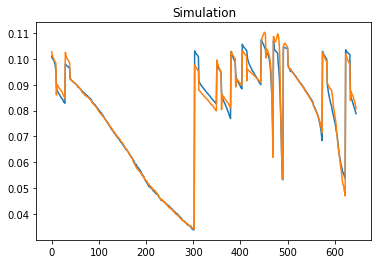

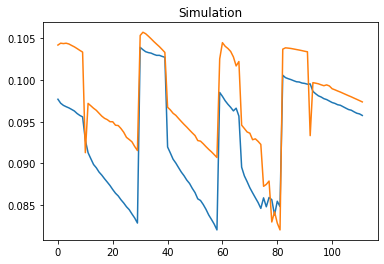

B0001
B0001
303
B0002
B0002
77
B0003
B0003
64
B0004
B0004
47
B0005
83
B0006
B0006
72
B0008


NotImplementedError: ignored

In [ ]:
Nb_Epochs = 75
Learning_Rate = 1e-5


Train_info, _, _, date = Train(train_loader, valid_loader, Model, Nb_Epochs,
                               plot_bool=True, LR=Learning_Rate, report=True,
                               sim_loader=sim_train_loader, print_bool=True,
                               device=device, remove_bool=True)

print(date)

# # Best model
simulate(sim_train_loader, Model, block=False, denormalize=True, device=device)
simulate(valid_loader, Model, block=False, denormalize=True, device=device)

Load_Save(date, device=device, plot_bool=False, dataset_name=dataset_name)